In [1]:
import pandas as pd,gensim,collections,numpy as np,math,matplotlib.pyplot as plt,re, string,os
from collections import defaultdict
from gensim import corpora, models, similarities
from collections import Counter
from utils.dataset import DataSet
from nltk import word_tokenize, sent_tokenize
import nltk, pickle
%matplotlib inline

stopwords = set(nltk.corpus.stopwords.words('english'))

In [2]:
def clean(s):
    return " ".join(re.findall(r'[\w\']+', s, flags=re.UNICODE)).lower()

def tfidf_vectorization(train_stance, dict_articles):
    # panda dataframe which has columns: 'Headline', 'Body ID', 'Stance'
    bodyids =  train_stance["Body ID"].values
    bodies = [ dict_articles[bodyid] for bodyid in dict_articles.keys() ]
    stances = train_stance["Stance"].values

    # tokenize each body
    words_per_body = []
    vocab_per_body = [] # for idf
    for body in bodies:
        words = word_tokenize(clean(body))
        words = [w for w in words if w not in string.punctuation and w not in stopwords]
        words_per_body.append(words)
        vocab_per_body += list(set(words))
    
    # tokenize each headlline
    headlines = train_stance["Headline"].values
    tokens_per_headline = []

    for head in headlines:
        words = word_tokenize(clean(head))
        words = [w for w in words if w not in string.punctuation and w not in stopwords]
        tokens_per_headline.append(words)

    # compute idf, only needs words set
    body_corpus_count = Counter(vocab_per_body)
    idf = {}
    
    for vocab in body_corpus_count.keys():
        D = len(dict_articles.keys())
        idf[vocab] = math.log( D / body_corpus_count[vocab])
        
    # calculate body tfidf and save in dict(body id)-dict(word) 
    tfidf_body_dict = {}
    
    for i, bodyid in enumerate(dict_articles.keys()):
        tf_body = Counter(words_per_body[i])
        total_words_in_body = len(words_per_body[i])
        
        tfidf_per_word_dict = {}
        for word in tf_body.keys():
            tf = tf_body[word]/total_words_in_body
            tfidf = tf * idf[word]
            tfidf_per_word_dict[word] = tfidf
            
        tfidf_body_dict[bodyid] = tfidf_per_word_dict
        
    # compute headline tfidf and save in dict - dict
    tfidf_headline_dict = {}
    
    for i,(head,bodyID) in enumerate(zip(headlines, bodyids)):
        current_headline_tfidf_dict = {}
        tokens = tokens_per_headline[i]
        token_counts = Counter(tokens)
        
        for word in tokens:
            if word in idf:
                tfidf = token_counts[word]/len(tokens)*idf[word]
                current_headline_tfidf_dict[word] = tfidf
        tfidf_headline_dict[i] = current_headline_tfidf_dict
        
    return tfidf_headline_dict, tfidf_body_dict, tokens_per_headline

In [3]:
def extract_features(headline_tfidf_dict, body_tfidf_dict, tokens_per_headline, bodyIDs):
    feature_cosine, feature_dis, feature_kl = [], [], []
    
    # loop through each headline 
    for i, bodyid in enumerate(bodyIDs):
        headline_tokens = tokens_per_headline[i]
        current_head_tfidf_dict = headline_tfidf_dict[i]
        current_body_tfidf_dict = body_tfidf_dict[bodyid]
        
        # loop through each word
        cosine = 0
        distance = 0
        kl = 0
        
        for word in headline_tokens:
            if word in current_body_tfidf_dict:
                vec1 = current_head_tfidf_dict[word]
                vec2 = current_body_tfidf_dict[word]
                cosine += vec1*vec2
                distance += (vec1-vec2)**2
                kl += vec1 * np.log(vec1 / vec2)
        # normalize vector dot        
        norm_headline = np.linalg.norm(list(current_head_tfidf_dict.values()))
        norm_body = np.linalg.norm(list(current_body_tfidf_dict.values()))
        cosine = cosine / norm_headline / norm_body
        feature_cosine.append(cosine)
        
        # square root distance
        distance = math.sqrt(distance)
        feature_dis.append(distance)
        feature_kl.append(kl)
        
    return feature_cosine, feature_dis, feature_kl

In [4]:
def feature_extraction_pipeline(train_stance, articles, file_save_path):
        
    headline_tfidf_dict, body_tfidf_dict, tokens_per_headline = tfidf_vectorization(train_stance, articles)
    bodyids = train_stance['Body ID'].values
    stances = train_stance['Stance'].values

    feature_cos, feature_dis, feature_kl = extract_features(headline_tfidf_dict, body_tfidf_dict, tokens_per_headline, bodyids)
    
    train_df = pd.DataFrame(np.column_stack([feature_cos, feature_dis, feature_kl, stances]), columns=['cos','dis', 'kl', 'Stance'])
    train_df.to_csv(file_save_path)
    return feature_cos, feature_dis, feature_kl

In [5]:
# process train data
train = DataSet('train')
train_stance = pd.read_csv('fnc-1/train_stance_pd.csv')
cosine, dis, kl = feature_extraction_pipeline( train_stance, train.articles, 'train_processed_feat.csv')

Reading dataset
Total stances: 49972
Total bodies: 1683


In [6]:
test = DataSet('competition_test')
# process test data
test_stance = pd.read_csv('fnc-1/competition_test_stances.csv')
cos2, dis2, kl2 = feature_extraction_pipeline( test_stance, test.articles, 'test_processed_feat.csv')

Reading dataset
Total stances: 25413
Total bodies: 904


# 验证 feature importance

In [35]:
class_index = {'agree':[], 'disagree':[], 'discuss':[], 'unrelated':[]}

for i,data in enumerate(train_stance.Stance):
    class_index[data].append(i)

f = kl
agree_cosine = [ f[index] for index in class_index['agree']]
disagree_cosine = [ f[index] for index in class_index['disagree']]
discuss_cosine = [ f[index] for index in class_index['discuss']]
unrelated_cosine = [ f[index] for index in class_index['unrelated']]

Text(0.5,0.98,'kl')

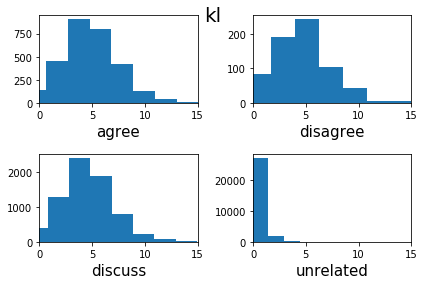

In [41]:
a = 0
b = 15
ax = plt.figure()
plt.subplot(2, 2, 1)
plt.hist(agree_cosine)
plt.xlim(a,b)
plt.xlabel('agree', fontsize = 15)
plt.subplot(2, 2, 2)
plt.hist(disagree_cosine)
plt.xlim(a,b)

plt.xlabel('disagree', fontsize = 15)
plt.subplot(2, 2, 3)
plt.hist(discuss_cosine)
plt.xlim(a,b)

plt.xlabel('discuss', fontsize = 15)
plt.subplot(2, 2, 4)
plt.hist(unrelated_cosine)
plt.xlim(a,b)

plt.xlabel('unrelated', fontsize = 15)
plt.tight_layout()

plt.suptitle('kl', fontsize = 20)
# plt.savefig('/Desktop/class_distribution_in_compound.png')

In [8]:
# stances = test_stance['Stance'].values
# plt.figure()
# plot_cos = []
# feature = cos2
# for (cos,stance) in zip(feature, stances):
#     if stance != 'unrelated':
#         plot_cos.append(cos)

# for cos,stance in zip(feature, stances):
#     if stance == 'unrelated':
#         plot_cos.append(cos)

# plt.plot(range(len(plot_cos)), plot_cos, 'g*')

# plt.figure()
# plot_cos = []
# feature = cosine
# stances = train_stance['Stance'].values
# for cos,stance in zip(feature, stances):
#     if stance != 'unrelated':
#         plot_cos.append(cos)

# for cos,stance in zip(feature, stances):
#     if stance == 'unrelated':
#         plot_cos.append(cos)

# plt.plot(range(len(plot_cos)), plot_cos, 'g*')

# plt.figure()
# plot_cos = []
# feature = kl
# for cos,stance in zip(feature, stances):
#     if stance != 'unrelated':
#         plot_cos.append(cos)

# for cos,stance in zip(feature, stances):
#     if stance == 'unrelated':
#         plot_cos.append(cos)

# plt.plot(range(len(plot_cos)), plot_cos, 'g*')

In [9]:
os.system('say "you are very beautiful"')

0